Pandas and GeoPandas allows us to create and manipulate spatial data files

In [1]:
import pandas as pd
import geopandas

Read ESRI shapefiles as GeoDataFrames

In [2]:
gi_df = geopandas.read_file("Data/project/green_infrastructure.geojson")
sewershed_df = geopandas.read_file("Data/project/Sewershed.shp")
csda_df = geopandas.read_file("Data/project/combinedsewer_drainage_area.shp")
print('Files have been read to DataFrames')


Files have been read to DataFrames


Select only the relevant columns and constructed green infrastructures

In [3]:
gi_df = gi_df[['asset_id', 'calc_rain', 'status', 'geometry']]
gi_df = gi_df[gi_df.status.str.contains('Constructed')]
gi_df.head()

,asset_id,calc_rain,status,geometry
83,104457.0,288.99,Constructed (Full Maintenance),POINT (989148.545 188880.241)
84,104484.0,170.42,Constructed (Full Maintenance),POINT (988675.400 188463.301)
85,104535.0,537.69,Constructed (Full Maintenance),POINT (988360.588 187911.543)
86,104537.0,316.74,Constructed (Full Maintenance),POINT (986091.581 188980.883)
87,104544.0,98.92,Constructed (Full Maintenance),POINT (986738.666 188393.443)


Spatially join the sewershed to the green infrastructure DataFrame

In [4]:
gi_with_sewershed = geopandas.sjoin(gi_df, sewershed_df, how='left', op='within')
gi_with_sewershed.head()

C:\ProgramData\Anaconda3\envs\geo_env\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'proj': 'lcc', 'lat_0': 40.1666666666667, 'lon_0': -74, 'lat_1': 40.6666666666667, 'lat_2': 41.0333333333333, 'x_0': 300000, 'y_0': 0, 'ellps': 'GRS80', 'units': 'us-ft', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)


,asset_id,calc_rain,status,geometry,index_right,Pervious,Impervious,Sewershed,Population,Housing,Acres,Squarefeet,GallonsH2O
83,104457.0,288.99,Constructed (Full Maintenance),POINT (989148.545 188880.241),10,21.528265,78.471735,RH,211284.0,104091.0,3610.07722,1.572543e+08,9.802187e+07
84,104484.0,170.42,Constructed (Full Maintenance),POINT (988675.400 188463.301),10,21.528265,78.471735,RH,211284.0,104091.0,3610.07722,1.572543e+08,9.802187e+07
85,104535.0,537.69,Constructed (Full Maintenance),POINT (988360.588 187911.543),10,21.528265,78.471735,RH,211284.0,104091.0,3610.07722,1.572543e+08,9.802187e+07
86,104537.0,316.74,Constructed (Full Maintenance),POINT (986091.581 188980.883),10,21.528265,78.471735,RH,211284.0,104091.0,3610.07722,1.572543e+08,9.802187e+07
87,104544.0,98.92,Constructed (Full Maintenance),POINT (986738.666 188393.443),10,21.528265,78.471735,RH,211284.0,104091.0,3610.07722,1.572543e+08,9.802187e+07


Calculate the total volume of rain each sewershed can hold with green infrastructures

In [5]:
gi_group = gi_with_sewershed.groupby('Sewershed')
tot_calc_rain = gi_group.sum().calc_rain
tot_calc_rain.name = 'total_calc_rain'
tot_calc_rain

Sewershed
26W    290626.88
BB     318869.30
CI      14546.26
HP     156399.29
JAM     71843.04
NC     469092.43
NR     112996.65
OB       1022.00
OH      61098.95
PR       3487.34
RH      38311.12
ROC      6005.33
TI      61325.52
WI      68878.65
Name: total_calc_rain, dtype: float64

Calculate the combined sewer areas for each sewershed

In [6]:
csda_group = csda_df.groupby('sewershed')
csda_area = csda_group.sum().area
csda_area.name = 'cso_area'
csda_area

sewershed
26W    2.655009e+08
BB     5.342237e+08
CI     2.676891e+08
HP     5.151588e+08
JAM    2.042443e+08
NC     5.844228e+08
NR     1.928891e+08
OH     4.177236e+08
PR     2.132374e+08
RH     1.289351e+08
TI     4.393674e+08
WI     4.677033e+08
Name: cso_area, dtype: float64

Join the total rain per sewershed and combined sewer areas to sewershed DataFrame

In [7]:
sewershed_rain = pd.merge(sewershed_df, tot_calc_rain, left_on='Sewershed', right_index=True)
sewershed_cso_rain = pd.merge(sewershed_rain, csda_area, left_on='Sewershed', right_index=True)
sewershed_cso_rain['rain_height'] = (sewershed_cso_rain.total_calc_rain / (sewershed_cso_rain.cso_area*0.10)) * 12
sewershed_cso_rain = sewershed_cso_rain[['Sewershed', 'Squarefeet', 'total_calc_rain', 
                                         'cso_area', 'rain_height', 'geometry']]
sewershed_cso_rain

,Sewershed,Squarefeet,total_calc_rain,cso_area,rain_height,geometry
0,26W,2.428252e+08,290626.88,2.655009e+08,0.131356,"MULTIPOLYGON (((1016624.205 173933.043, 101663..."
1,BB,7.004172e+08,318869.30,5.342237e+08,0.071626,"MULTIPOLYGON (((994939.730 212343.775, 994930...."
2,CI,6.258680e+08,14546.26,2.676891e+08,0.006521,"MULTIPOLYGON (((1007348.680 157321.910, 100738..."
3,HP,7.816187e+08,156399.29,5.151588e+08,0.036431,"MULTIPOLYGON (((1015019.860 230328.130, 101501..."
4,JAM,1.177900e+09,71843.04,2.042443e+08,0.042210,"POLYGON ((1029262.313 177311.156, 1029240.687 ..."
5,NC,6.496670e+08,469092.43,5.844228e+08,0.096319,"MULTIPOLYGON (((994757.119 185327.122, 994498...."
6,NR,2.391886e+08,112996.65,1.928891e+08,0.070297,"POLYGON ((988449.438 225821.953, 988454.250 22..."
8,OH,5.624814e+08,61098.95,4.177236e+08,0.017552,"MULTIPOLYGON (((984815.644 153040.809, 984805...."
9,PR,4.404987e+08,3487.34,2.132374e+08,0.001963,"POLYGON ((963846.750 174344.890, 963842.937 17..."
10,RH,1.572543e+08,38311.12,1.289351e+08,0.035656,"MULTIPOLYGON (((980326.374 183308.652, 980290...."


matplotlib lets us create figures

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable

Plot the combined sewer areas

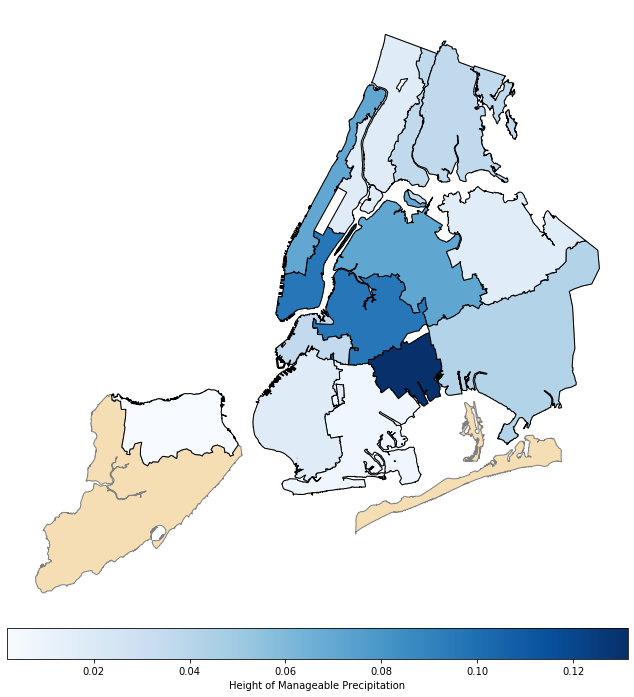

In [9]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
ss_fig = sewershed_df.plot(ax=ax, color='wheat', edgecolor='grey')
cs_fig = sewershed_cso_rain.plot(ax=ax, column='rain_height', edgecolor='black', cmap='Blues', 
                                 cax=cax, legend=True, 
                                 legend_kwds={'label': "Height of Manageable Precipitation", 'orientation': "horizontal"})

Label each polygon with the height of rain that can be handled in inches

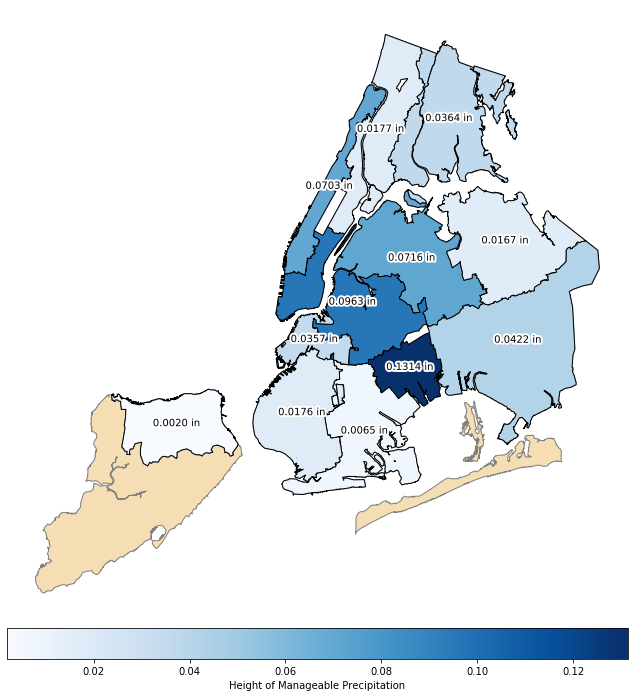

In [10]:
sewershed_cso_rain.apply(lambda x: cs_fig.annotate(s='{:.4f} in'.format(x['rain_height']),
                                                   xy=x.geometry.centroid.coords[0],
                                                   ha='center',
                                                   color='black',
                                                   path_effects=[pe.withStroke(linewidth=4, foreground="white")]),
                         axis=1)
fig

Label sewershed with name

0     Annotation(1.01549e+06, 181005, '26W')
1      Annotation(1.01601e+06, 210879, 'BB')
2      Annotation(1.00305e+06, 163610, 'CI')
3      Annotation(1.02613e+06, 249057, 'HP')
4     Annotation(1.04502e+06, 188448, 'JAM')
5           Annotation(999766, 198864, 'NC')
6           Annotation(993419, 230535, 'NR')
8           Annotation(985969, 168637, 'OH')
9           Annotation(951677, 165628, 'PR')
10          Annotation(989369, 188625, 'RH')
12     Annotation(1.04154e+06, 215608, 'TI')
13     Annotation(1.00751e+06, 246104, 'WI')
dtype: object

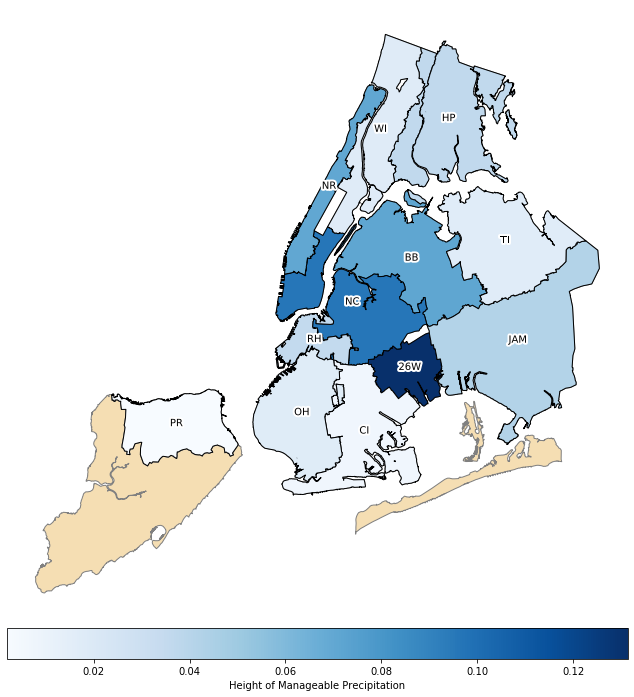

In [11]:
plt.close()
fig, ax = plt.subplots(figsize=(12, 12))
plt.axis('off')
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
ss_fig = sewershed_df.plot(ax=ax, color='wheat', edgecolor='grey')
cs_fig = sewershed_cso_rain.plot(ax=ax, column='rain_height', edgecolor='black', cmap='Blues', 
                                 cax=cax, legend=True, 
                                 legend_kwds={'label': "Height of Manageable Precipitation", 'orientation': "horizontal"})
sewershed_cso_rain.apply(lambda x: ss_fig.annotate(s=x['Sewershed'],
                                                   xy=x.geometry.centroid.coords[0],
                                                   ha='center',
                                                   color='black',
                                                   path_effects=[pe.withStroke(linewidth=4, foreground="white")]),
                         axis=1)